In [1]:
!pip install deap

     |████████████████████████████████| 160 kB 5.5 MB/s 


In [4]:
#from https://deap.readthedocs.io/en/master/examples/gp_symbreg.html#refpaperssymbreg
import operator
import math
import random

import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

x_points = [x/10. for x in range(-10,11)]
y_points = np.array([0.0, -0.1629, -0.2624, -0.3129, -0.3264, -0.3125, -0.2784, -0.2289, -0.1664, -0.0909, 0.0, 0.1111, 0.2496, 0.4251, 0.6496, 0.9375, 1.3056, 1.7731, 2.3616, 3.0951, 4.0])

# Define new functions
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

def protectedLog(val):
    try:
        return math.log(val)
    except:
        return -10000

# Add primitive functions and terminal set
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.exp, 1)
pset.addPrimitive(protectedLog, 1)
pset.addEphemeralConstant("2", lambda: random.uniform(-1,1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Define the fitness function
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the absolute error
    sqerrors = (abs(func(x) - y_points[np.where(np.array(x_points) == x)][0]) for x in points)
    return math.fsum(sqerrors),

# Define necessary operations
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,11)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

random.seed(318)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)

# Define stats
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Execute algorithm
pop, log = algorithms.eaSimple(pop, toolbox, 0.7, 0.0, 50, stats=mstats,
                                halloffame=hof, verbose=True)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max        	min    	nevals	std    	avg  	gen	max	min	nevals	std    
0  	1000  	19328.4	0  	1.99984e+06	5.45326	1000  	89431.1	3.392	0  	7  	2  	1000  	1.43608
1  	724   	4759.9 	1  	210013     	4.24698	724   	28100.6	3.253	1  	9  	2  	724   	1.36711
2  	658   	561.462	2  	210013     	4.24698	658   	8671   	3.293	2  	8  	2  	658   	1.33085
3  	710   	1582.44	3  	210013     	3.89252	710   	15155.2	3.322	3  	9  	2  	710   	1.35806
4  	722   	455.413	4  	110021     	3.89252	722   	6943.45	3.42 	4  	8  	2  	722   	1.41053
5  	712   	13.9155	5  	106.389    	3.89252	712   	7.34418	3.61 	5  	8  	2  	712   	1.45942
6  	668   	122.769	6  	110010     	3.89252	668   	3476.69	4.043	6  	9  	2  	668   	1.47077
7  	724   	122.579	7  	110021     	2.21733

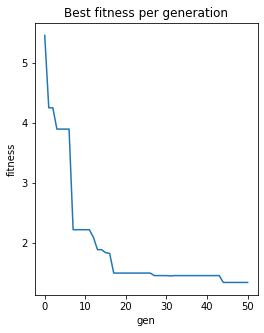

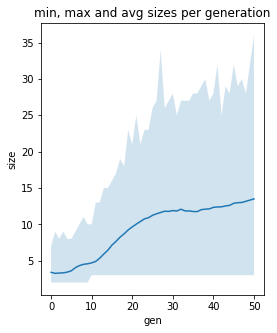

In [28]:
import matplotlib.pyplot as plt

#obtain data from log
gen = log.select("gen")
fit_mins = log.chapters["fitness"].select("min")
size_avgs = log.chapters["size"].select("avg")
size_min = log.chapters["size"].select("min")
size_max = log.chapters["size"].select("max")

fig1, ax1 = plt.subplots(figsize=(4,5))
ax1.plot(gen, fit_mins)
plt.title('Best fitness per generation')
plt.xlabel('gen')
plt.ylabel('fitness')
plt.show()

fig, ax = plt.subplots(figsize=(4,5))
ax.plot(gen, size_avgs, label='avg. size')
plt.title('min, max and avg sizes per generation')
plt.xlabel('gen')
plt.ylabel('size')
ax.fill_between(gen, size_min, size_max, alpha=0.2)
plt.show()